<a href="https://colab.research.google.com/github/SamuelBFG/DL-studies/blob/master/%5B261663%5DQ5_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IA353 - Redes Neurais
# EF2 - Questão 5 - Parte 2

### Um sistema de comunicação simples consiste em 3 módulos principais: transmissor, canal, e receptor. O transmissor envia uma mensagem ao receptor pelo canal, e a comunicação é dita bemsucedida se o receptor e o transmissor concordarem no que foi enviado. 

### Isso pode ser visto como um Autoencoder [[1]](https://ieeexplore.ieee.org/document/8054694), onde seu codificador atua como o transmissor do sistema de comunicação, e seu decodificador atua como o receptor. O canal atua como as restrições intrínsecas do Autoencoder.


### O objetivo desse notebook é reformular o problema de engenharia de um sistema de comunicação simples, em termos de sua camada física, em um problema de aprendizado profundo com um Autoencoder.


### Para comparação, adotaremos a taxa de erro na mensagem (block error rate, BLER) como medida de performance em alguma modulação tradicionalmente usada em engenharia de comunicações.

**Professor:** Fernando J. Von Zuben <br>
**Aluno(a):**  Samuel Borges Ferreira Gomes

## 5.1. Imports

In [1]:
# import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.compat.v1 as tf

tf.disable_v2_behavior() 

Instructions for updating:
non-resource variables are not supported in the long term


## 5.2. Modelo de sistema de comunicação simples

![Comunicação tradicional](https://i.imgur.com/0nQ4X8K.png)

A tarefa do transmissor é selecionar e mapear símbolos de uma fonte de informação $w\in\mathcal{W}=\{1,2,\ldots,M\}$ em uma sequência de $n$ símbolos do canal  $\mathbf{x}\in\mathbb{R}^{n}$ que compõem o sinal transmitido, realizando $n$ usos discretos do canal. Para isto, aplica a transformação $f\colon\mathcal{W}\mapsto\mathbb{R}^{n}$ na mensagem $s$ afim de gerar o sinal transmitido $\mathbf{x}=f(w)\in \mathbb{R}^{n}$. O vetor transmitido é sujeito a uma restrição de potência no *hardware* tal que $||\mathbf{x}||_{2}^2 \leq n$. Cada mensagem é representada por uma sequência de *bits* de comprimento $k=log_{2}(M)$. Desse modo, a taxa de comunicação deste sistema de comunicação é $R=k/n$ [*bits*/transmissão]. 

O canal age como um sistema estocástico descrito por sua matriz de transição definida pela função densidade de probabilidade condicional $p(\mathbf{y}|\mathbf{x})$ entre sua entrada e saída. Na recepção, uma versão possivelmente distorcida $\mathbf{y}\in\mathbb{R}^{n}$ de $\mathbf{x}$ pode ser observada. Desse modo, o objetivo do receptor é aplicar a transformação determinística  $g\colon\mathbb{R}^{n}\mapsto\mathcal{W}$ afim de produzir uma estimativa $\hat{w}=g(\mathbf{y})$ da mensagem original $w$ com erro arbitrariamente pequeno.

A relação entrada-saída do canal do $i$-ésimo uso de canal pode ser visto na forma


$y_{i}=x_{i} +n_{i}$,

em que $n_{i}\sim \mathcal{N}(0,N_{0}/2)$. A densidade espectral do ruído é dada por $N_{0}$, enquanto $x_{i}$ e $y_{i}$ representam a entrada e a saída do canal, respectivamente.


## 5.3. Autoencoder como sistema de comunicação fim-a-fim

In [2]:
k = 8          # Número de bits de informação por mensagem
n = 8          # Número de usos discretos do canal
M = 2**k       # Número de mensagens

### Criamos as mensagens que queremos transmitir em cada batch, extraídas de uma distribuição uniforme.

### **Para treinar eficientemente sob método de otimização iterativo, consideramos que essa entrada é codificada em um vetor *one-hot!***

In [3]:
# AUTOENCODER SYSTEM MODEL
batch_size = tf.placeholder(tf.int32,shape=[])
w = tf.random.uniform(shape=[batch_size],minval=0,maxval=M,dtype=tf.int32)
w_one_hot = tf.one_hot(w,depth=M)

### Autoencoder

In [4]:
# Transmitter
tx = tf.keras.layers.Dense(units=M,activation="relu")(w_one_hot)
tx = tf.keras.layers.Dense(units=n,activation=None)(tx)
x = tx / tf.sqrt(tf.reduce_mean(tf.square(tx)))

# Channel
noise_std = tf.placeholder(dtype=tf.float32,shape=[])
noise = tf.random.normal(shape=tf.shape(x),stddev=noise_std)
y = x + noise

# Receiver
rx = tf.keras.layers.Dense(units=M, activation="relu")(y)
w_hat = tf.keras.layers.Dense(units=M, activation=None)(rx)

- Transmissor: A primeira camada transmissora densa deve ter ativação "relu"  e pode ter qualquer número de unidades, sendo escolhida igual a $M$ para ser coerente com a ordem de modulação. A segunda camada densa deve ter $n$ unidades, formando a saída de o transmissor, que não deve ter nenhuma função de ativação, uma vez que queremos que o transmissor seja capaz de emitir quaisquer números de valor real. Para evitar que o transmissor aprenda saídas desnecessariamente grandes e se torne numericamente instável, normalizamos a potência média de todas as saídas do transmissor no *mini-batch* para igual a 1.

- Canal: Para efeitos de simplicidade, adota-se o canônico ruído gaussiano branco aditivo básico (AWGN), que simplesmente adiciona no sinal transmitido valores aleatoriamente extraídos de uma distribuição normal com variância correspondendo a densidade espectral do ruído. 

- Receptor: Dependendo da complexidade do modelo de canal, podemos agora adicionar várias dessas camadas ao nosso modelo para aumentar a complexidade e os recursos da rede neural. Mas para o canal AWGN simples, uma camada de entrada com ativação ReLU e uma de saída são suficientes no lado do receptor. A camada densa de saída deve ter M unidades, uma vez que queremos produzir uma previsão sobre a probabilidade de cada mensagem possível. 



Usamos uma função de perda de entropia cruzada padrão que inerentemente ativa os logits com “softmax” e aceita rótulos esparsos.

In [5]:
# Loss function
cross_entropy = tf.losses.sparse_softmax_cross_entropy(labels=w, logits=w_hat)

Calculamos a taxa média de erro de mensagem (ou bloco) do *mini-batch* decidindo com *hard-decision* a saída do receptor no elemento com a maior probabilidade (argmax).

In [6]:
# Metrics
correct_predictions = tf.equal(tf.argmax(tf.nn.softmax(w_hat),axis=1,output_type=tf.int32),w)
accuracy = tf.reduce_mean(tf.cast(correct_predictions,dtype=tf.float32))
bler = 1.0 - accuracy

Adotamos Adam como otimizador.

In [7]:
# Optimizer
lr = tf.placeholder(dtype=tf.float32,shape=[])
train_op = tf.train.AdamOptimizer(learning_rate=lr).minimize(cross_entropy)

In [8]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

Formulamos uma definição de relação sinal ruído (SNR) por bit média $E_{b}/N_{0}$, para que possamos treinar facilmente em determinada SNR. Esta função simplesmente calcula o desvio padrão do ruído para um determinada SNR (enquanto a potência do sinal é normalizada para 1)

In [9]:
def EbNo2Sigma(ebnodb):
  '''Convert Eb/No in dB to noise standard deviation'''
  ebno = 10**(ebnodb/10)
  bits_per_complex_symbol = k/(n/2)
  return 1.0/np.sqrt(bits_per_complex_symbol*ebno)

Treinamento: Começamos com 1.000 iterações de execução da função train_op com um pequeno batch_size de apenas 100 mensagens e uma taxa de aprendizado de 0,001. Após essa primeira época de treinamento, reduzimos a taxa de aprendizado para 0,0001 e executamos outra época com 10.000 iterações. Para a última época de treinamento, aumentamos o tamanho do lote para 1.000 e executamos outras 10.000 iterações. Durante todos os períodos de treinamento, definimos a SNR de treinamento para 7 dB.

In [10]:
for i in range(1000):
  sess.run(train_op, feed_dict={batch_size: 100, noise_std: EbNo2Sigma(7.0), lr: 0.001})

for i in range(10000):
  sess.run(train_op, feed_dict={batch_size: 100, noise_std: EbNo2Sigma(7.0), lr: 0.0001})

for i in range(10000):
  sess.run(train_op, feed_dict={batch_size: 1000, noise_std: EbNo2Sigma(7.0), lr: 0.0001})

## 5.4. Análise de performance

Vamos verificar o desempenho do autoencoder plotando sua BLER em uma faixa de SNR. Portanto, precisamos executar uma simulação de Monte Carlo para obter uma BLER precisa para cada ponto SNR. Neste exemplo, simulamos a BLER de 0 a 14dB executando 10 *mini-batchtes* de 100.000 mensagens para cada ponto SNR.

In [11]:
snr_range = np.linspace(0,14,15)
monte_carlo_bler = np.zeros((len(snr_range),))
for i in range(len(snr_range)):
  for j in range(10):
    monte_carlo_bler[i] += sess.run(bler, feed_dict={batch_size: 100000, noise_std: EbNo2Sigma(snr_range[i]), lr: 0.0})
monte_carlo_bler = monte_carlo_bler / 10

(1e-05, 1)

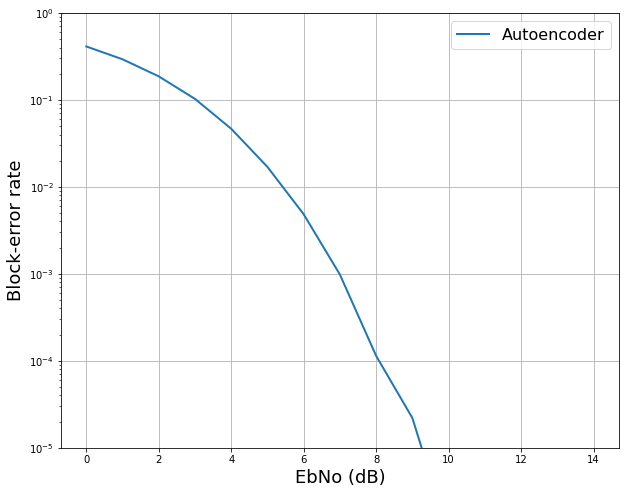

In [12]:
plt.figure(figsize=(10,8))
plt.plot(snr_range, monte_carlo_bler, linewidth=2.0)
plt.legend(['Autoencoder'], prop={'size': 16}, loc='upper right');
plt.yscale('log')
plt.xlabel('EbNo (dB)', fontsize=18)
plt.ylabel('Block-error rate', fontsize=18)
plt.grid(True)
plt.ylim([1e-5,1])

## 5.5. Comparação com esquema clássico de modulação

Agora é possível comparar esse desempenho com outros esquemas de modulação. Neste exemplo, o Autoencoder se comunica a uma taxa $R=8/8=1$, de forma que fornecemos [[2]](https://mlc.committees.comsoc.org/2019/08/23/learning-to-communicate-hands-on-coding/) a BLER para o esquema binário de modulação de fase e quadratura (BPSK) não codificado.

(0.0, 10.0)

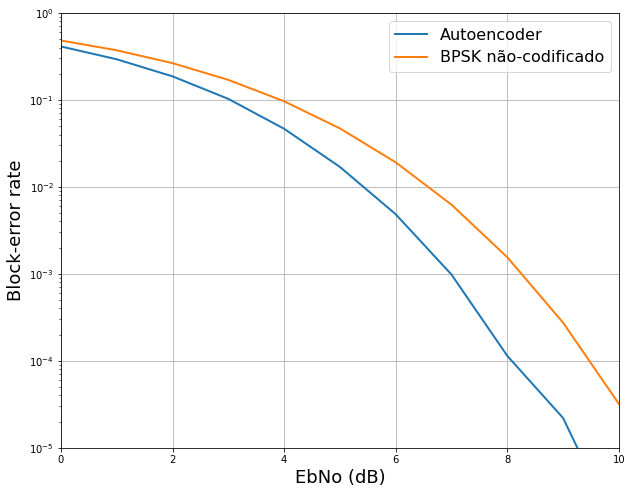

In [16]:
BLER_QPSK_k8n8 = np.array([4.818329E-01, 3.720104E-01, 2.645386E-01, 1.698987E-01, 9.636992E-02, 4.703772E-02, 1.914436E-02, 6.244719E-03, 1.551032E-03, 2.745986E-04, 3.194809E-05, 2.384186E-06, 0.000000E+00, 0.000000E+00, 0.000000E+00])

plt.figure(figsize=(10,8))
plt.plot(snr_range, monte_carlo_bler, linewidth=2.0)
plt.plot(snr_range, BLER_QPSK_k8n8, linewidth=2.0)
plt.legend(['Autoencoder', 'BPSK não-codificado'], prop={'size': 16}, loc='upper right');
plt.yscale('log')
plt.xlabel('EbNo (dB)', fontsize=18)
plt.ylabel('Block-error rate', fontsize=18)
plt.grid(True)
plt.ylim([1e-5,1])
plt.xlim([0,10])

## 5.6. Conclusões

Para o cenário adotado, o desempenho do Autoencoder implica que ele aprendeu algum esquema de codificação e modulação conjunta, sem qualquer conhecimento a priori de engenharia de comunicações, de modo que um ganho de codificação foi obtido. Além disso, sistemas dessa natureza apontam um interessante gradiente para problemas cujo modelos não sejam matematicamente tratáveis.

## 5.7. Referências

[[1]](https://ieeexplore.ieee.org/document/8054694) An Introduction to Deep Learning for the Physical Layer

[[2]](https://mlc.committees.comsoc.org/2019/08/23/learning-to-communicate-hands-on-coding/) Learning to Communicate: Hands-on Coding